# Perfect vs Semi-perfect

Comparison of the perfect gas model with the semi-perfect gas model. Will be based on the CFM56-3 model, but will exclude all the features that are only available using the 'cantera' model.

#### References:
[1] - Martins, 2015, _Off-Design Performance Prediction of the CFM56-3 Aircraft
Engine_

In [26]:
import gazania as gaz
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

# Data from page 35 of Ref [1]
thrust = 99.72e3   # Not used in our model - just for reference

mdot_f = 1.0951
LCV = 42.769e6
mdot_in = 313.798
BPR = 4.9386

# Ground level and stationary
p_in = 101325
T_in = 288.15
V_in = 0.0

Using cantera's imperfect gas model:

In [27]:
# Compression system
LPC_core = gaz.Compressor(isen = 0.89, PR = 1)
LPC_bypass = gaz.Compressor(isen = 0.9001, PR = 1.655)
IPC = gaz.Compressor(isen = 0.8776, PR = 2.182)
HPC = gaz.Compressor(isen = 0.8677, PR = 11.069)

# Combustor
heat_in = gaz.HeatExchanger(Qdot = mdot_f * LCV, PR = 1.0)                        # Input fuel heat at these new properties

# Turbines
HPT = gaz.Turbine(isen = 0.8500, PR = 4.082)
LPT = gaz.Turbine(isen = 0.8713, PR = 3.846)

# Nozzle
nozzle_bypass = gaz.Nozzle(type = "C", p_amb = p_in) 
nozzle_core = gaz.Nozzle(type = "C", p_amb = p_in)

# Set up turbofan
core_components = [LPC_core, 
                   IPC, 
                   HPC, 
                   heat_in,
                   HPT, 
                   LPT, 
                   nozzle_core]
    
bypass_components = [LPC_bypass, 
                     nozzle_bypass]

turbofan_ct = gaz.engine.Turbofan(mdot_in = mdot_in,
                                  BPR = BPR,
                                  bypass_components = bypass_components,
                                  core_components = core_components,
                                  p_in = p_in,
                                  T_in = T_in,
                                  V_in = V_in,
                                  model = "cantera")

turbofan_ct.solve()

Exactly the same as above, but setting model = 'perfect'.

In [28]:
turbofan_pg = gaz.engine.Turbofan(mdot_in = mdot_in,
                                  BPR = BPR,
                                  bypass_components = bypass_components,
                                  core_components = core_components,
                                  p_in = p_in,
                                  T_in = T_in,
                                  V_in = V_in,
                                  model = "perfect")
turbofan_pg.solve()


PG = perfect gas (gamma = 1.4, cp = 1005 J/kg/K)
CT = cantera (ideal but imperfect gas)

----------------COMPARISON----------------
Compressor Power (PG) = 39.72394463858202 MW
Compressor Power (CT) = 39.51946694860862 MW
PG % error = 0.5174100405739548 %

Turbine Power (PG) = -42.77432450275919 MW
Turbine Power (CT) = -41.12373871028337 MW
PG % error = 4.013705573085656 %

Combustor exit temperature (PG) = 1673.3778838544406 K
Combustor exit temperature (CT) = 1533.5210643952537 K
PG % error = 9.119980331951924 %


Thrust (PG) = 102.47190733939506 kN
Thrust (CT) = 102.54677019557164 kN
PG % error = -0.07300362169750016 %




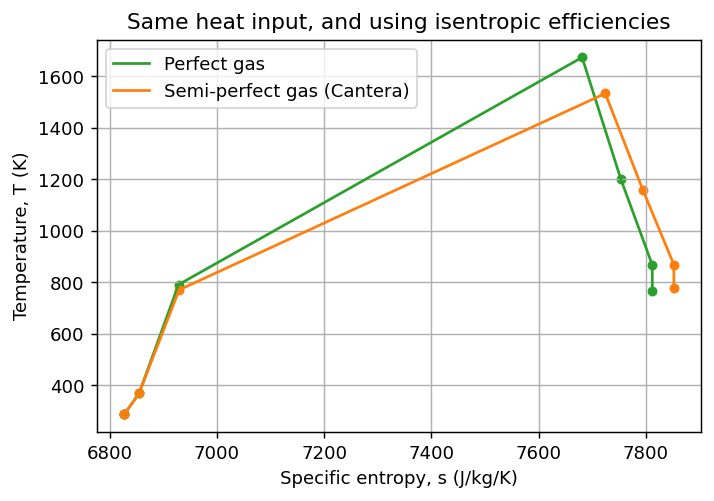

In [29]:
print(f"""
PG = perfect gas (gamma = 1.4, cp = 1005 J/kg/K)
CT = cantera (ideal but imperfect gas)

----------------COMPARISON----------------
Compressor Power (PG) = {turbofan_pg.compressor_power/1e6} MW
Compressor Power (CT) = {turbofan_ct.compressor_power/1e6} MW
PG % error = {100*(turbofan_pg.compressor_power - turbofan_ct.compressor_power)/turbofan_ct.compressor_power} %

Turbine Power (PG) = {turbofan_pg.turbine_power/1e6} MW
Turbine Power (CT) = {turbofan_ct.turbine_power/1e6} MW
PG % error = {100*(turbofan_pg.turbine_power - turbofan_ct.turbine_power)/turbofan_ct.turbine_power} %

Combustor exit temperature (PG) = {turbofan_pg.core_cycle.T[4]} K
Combustor exit temperature (CT) = {turbofan_ct.core_cycle.T[4]} K
PG % error = {100*(turbofan_pg.core_cycle.T[4] - turbofan_ct.core_cycle.T[4])/turbofan_ct.core_cycle.T[4]} %


Thrust (PG) = {turbofan_pg.thrust/1e3} kN
Thrust (CT) = {turbofan_ct.thrust/1e3} kN
PG % error = {100*(turbofan_pg.thrust - turbofan_ct.thrust)/turbofan_ct.thrust} %

""")

#  T-S plot of core cycles 
T_ct = turbofan_ct.core_cycle.T
T_pg = turbofan_pg.core_cycle.T

p_ct = turbofan_ct.core_cycle.p
p_pg = turbofan_pg.core_cycle.p

s_ct = np.zeros(len(T_ct))
s_pg = np.zeros(len(T_pg))

air = ct.Solution('gri30.yaml')         # Cantera Solution object that will be edited to calculate properties
air.Y = gaz.AIR_COMP

for i in range(len(T_ct)):
    air.TP = T_ct[i], p_ct[i]
    s_ct[i] = air.s
    
    if i == 0:
        s_pg[i] = s_ct[i]
    else:
        R = turbofan_pg.core_cycle.cp[i] * (1 - 1/turbofan_pg.core_cycle.gamma[i])
        s_pg[i] = s_pg[i-1] + turbofan_pg.core_cycle.cp[i] * np.log(T_pg[i]/T_pg[i-1]) - R * np.log(p_pg[i]/p_pg[i-1])

# Labels
plt.title("Same heat input, and using isentropic efficiencies")
plt.xlabel("Specific entropy, s (J/kg/K)")
plt.ylabel("Temperature, T (K)")
plt.grid()
        
plt.plot(s_pg, T_pg, label = "Perfect gas", color = "C2")#, linestyle = "dotted")
plt.scatter(s_pg, T_pg, s = 20, marker = "o", color = "C2")
plt.legend()

#plt.savefig("img/perfect_isen.svg")

plt.plot(s_ct, T_ct, label = "Semi-perfect gas (Cantera)", color = "C1")
plt.scatter(s_ct, T_ct, s = 20, marker = "o", color = "C1")
plt.legend()

plt.savefig("img/perfect_imperfect_isen.svg")

Run the same thing, but using polytropic efficiencies instead of isentropic, and defining a combustor outlet temperature.

In [30]:
# Compression system
LPC_core = gaz.Compressor(poly = 0.89, PR = 1)
LPC_bypass = gaz.Compressor(poly = 0.9001, PR = 1.655)
IPC = gaz.Compressor(poly = 0.8776, PR = 2.182)
HPC = gaz.Compressor(poly = 0.8677, PR = 11.069)

# Combustor
heat_in = gaz.HeatExchanger(T_out = 1600, PR = 1.0)                     

# Turbines
HPT = gaz.Turbine(poly = 0.8500, PR = 4.082)
LPT = gaz.Turbine(poly = 0.8713, PR = 3.846)

# Nozzle
nozzle_bypass = gaz.Nozzle(type = "C", p_amb = p_in)
nozzle_core = gaz.Nozzle(type = "C", p_amb = p_in)

# Set up turbofan
core_components = [LPC_core, 
                   IPC, 
                   HPC, 
                   heat_in,
                   HPT, 
                   LPT, 
                   nozzle_core]
    
bypass_components = [LPC_bypass, 
                     nozzle_bypass]

turbofan_ct = gaz.engine.Turbofan(mdot_in = mdot_in,
                                  BPR = BPR,
                                  bypass_components = bypass_components,
                                  core_components = core_components,
                                  p_in = p_in,
                                  T_in = T_in,
                                  V_in = V_in,
                                  model = "cantera")


turbofan_pg = gaz.engine.Turbofan(mdot_in = mdot_in,
                                  BPR = BPR,
                                  bypass_components = bypass_components,
                                  core_components = core_components,
                                  p_in = p_in,
                                  T_in = T_in,
                                  V_in = V_in,
                                  model = "perfect")

turbofan_ct.solve()
turbofan_pg.solve()


PG = perfect gas (gamma = 1.4, cp = 1005 J/kg/K)
CT = cantera (ideal but imperfect gas)

----------------COMPARISON----------------
Compressor Power (PG) = 41.34136474853414 MW
Compressor Power (CT) = 41.01762033147224 MW
PG % error = 0.7892813245762531 %

Turbine Power (PG) = -41.789277190491724 MW
Turbine Power (CT) = -43.80180464719671 MW
PG % error = -4.5946222374054395 %

Combustor exit temperature (PG) = 1600.0 K
Combustor exit temperature (CT) = 1600.0 K
PG % error = 0.0 %


Thrust (PG) = 101.75697516108717 kN
Thrust (CT) = 102.9651775424705 kN
PG % error = -1.173408729261861 %




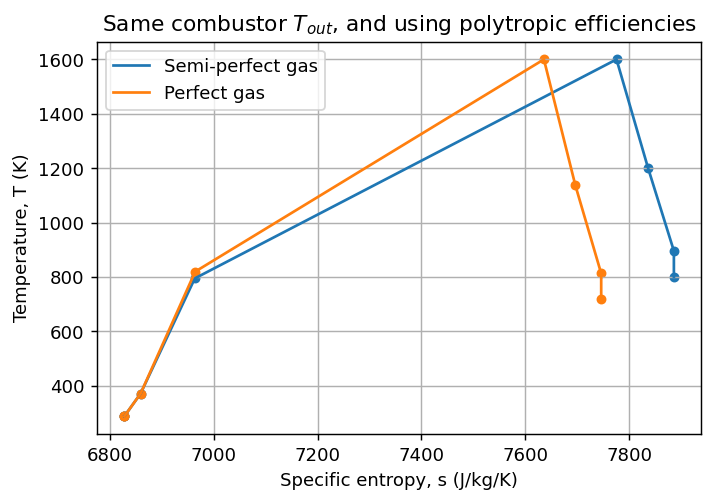

In [31]:
print(f"""
PG = perfect gas (gamma = 1.4, cp = 1005 J/kg/K)
CT = cantera (ideal but imperfect gas)

----------------COMPARISON----------------
Compressor Power (PG) = {turbofan_pg.compressor_power/1e6} MW
Compressor Power (CT) = {turbofan_ct.compressor_power/1e6} MW
PG % error = {100*(turbofan_pg.compressor_power - turbofan_ct.compressor_power)/turbofan_ct.compressor_power} %

Turbine Power (PG) = {turbofan_pg.turbine_power/1e6} MW
Turbine Power (CT) = {turbofan_ct.turbine_power/1e6} MW
PG % error = {100*(turbofan_pg.turbine_power - turbofan_ct.turbine_power)/turbofan_ct.turbine_power} %

Combustor exit temperature (PG) = {turbofan_pg.core_cycle.T[4]} K
Combustor exit temperature (CT) = {turbofan_ct.core_cycle.T[4]} K
PG % error = {100*(turbofan_pg.core_cycle.T[4] - turbofan_ct.core_cycle.T[4])/turbofan_ct.core_cycle.T[4]} %


Thrust (PG) = {turbofan_pg.thrust/1e3} kN
Thrust (CT) = {turbofan_ct.thrust/1e3} kN
PG % error = {100*(turbofan_pg.thrust - turbofan_ct.thrust)/turbofan_ct.thrust} %

""")

#  T-S plot of core cycles 
T_ct = turbofan_ct.core_cycle.T
T_pg = turbofan_pg.core_cycle.T

p_ct = turbofan_ct.core_cycle.p
p_pg = turbofan_pg.core_cycle.p

s_ct = np.zeros(len(T_ct))
s_pg = np.zeros(len(T_pg))

air = ct.Solution('gri30.yaml')         # Cantera Solution object that will be edited to calculate properties
air.Y = gaz.AIR_COMP

for i in range(len(T_ct)):
    air.TP = T_ct[i], p_ct[i]
    s_ct[i] = air.s
    
    if i == 0:
        s_pg[i] = s_ct[i]
    else:
        R = turbofan_pg.core_cycle.cp[i] * (1 - 1/turbofan_pg.core_cycle.gamma[i])
        s_pg[i] = s_pg[i-1] + turbofan_pg.core_cycle.cp[i] * np.log(T_pg[i]/T_pg[i-1]) - R * np.log(p_pg[i]/p_pg[i-1])

plt.plot(s_ct, T_ct, label = "Semi-perfect gas")
plt.scatter(s_ct, T_ct, s = 20, marker = "o")

plt.plot(s_pg, T_pg, label = "Perfect gas")
plt.scatter(s_pg, T_pg, s = 20, marker = "o")

# Labels
plt.title(r"Same combustor $T_{out}$, and using polytropic efficiencies")
plt.xlabel("Specific entropy, s (J/kg/K)")
plt.ylabel("Temperature, T (K)")
plt.legend()
plt.grid()

plt.savefig("img/perfect_imperfect_poly.svg")